# Disco Learning Dynamics
In this notebook, we will generate a toy dataset that vaguely looks like a particle physics problem, and then study the learning dynamics of NNs trained with the DisCO (distance correlation) loss function.

## Set up tensorflow
NB: I'm using TF2.1 and tf.keras, but you might be able to substitute for standalone keras and a different TF version. Not sure.

In [1]:
# Some boilerplate to configure the GPU on my system
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
import tensorflow_probability as tfp

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats

## Generate toy data

We will generate a dataset of "signal" and "background" examples comprised of three features which are qualitatively meant to represent a jet's $p_\mathrm{T}$, mass, and a ficticious, uncorrelated "substructure" variable, d.
The joint pdfs for signal and bg processes will be known exactly, allowing us to compare the NN results with the Neyman-Pearson optimal result from the likelihood ratio.

### PDFs
The probability density for a signal event with $(p_\mathrm{T}, d, m) = (x,y,z)$ is given by $P_{sig}(x,y,z) = P_{sig,p_\mathrm{T}}(x)P_{sig,d}(y)P_{sig,m}(z)$ where:

$$\begin{align}
P_{sig,p_\mathrm{T}}(x;\beta_s) &= \frac{1}{\beta_s}e^{-x/\beta_s} \\
P_{sig,d}(y;k_s,\theta_s) &= \mathrm{Gamma}(y; k_s, \theta_s) \\
P_{sig,m}(z;\mu,\sigma) &= \mathcal{N}(z; \mu, \sigma) \,,
\end{align}
$$
i.e., the $p_\mathrm{T}$ is exponentially distributed, the mass is a gaussian, and the observable $d$ follows a Gamma distribution.
The parameters $\beta_s, k_s, \theta_s, \mu$ and $\sigma$ are constants that are chosen arbitrarily, and the Gamma distribution is defined by:

$$
\mathrm{Gamma}(x;k,\theta) = \frac{1}{\theta^k\Gamma(k)}x^{k-1}e^{-x/\theta}
$$

The probability density for a background event $(p_\mathrm{T},d,m)$ is given by $P_{bg}(x,y,z) = P_{bg,p_\mathrm{T}}(x)P_{bg,d}(y)P_{bg,m}(z|x)$.
Note that unlike the signal process, **the background has a $p_\mathrm{T}$-dependent mass distribution**.
The individual terms in the PDF are given by:

$$
\begin{align}
P_{bg,p_\mathrm{T}}(x;\beta_b) &= \frac{1}{\beta_b}e^{-x/\beta_b} \\
P_{bg,d}(y;k_b,\theta_b^{(d)}) &= \mathrm{Gamma}(y; k_b, \theta_b^{(d)}) \\
P_{bg,m}(z|x;\theta_b^{(m)}) &= \mathrm{Gamma}(z; 1+4x, \theta_b^{(m)}) \\ \,.
\end{align}
$$
Again, $p_\mathrm{T}$ and $d$ follow exponential and Gamma distributions, respectively, albeit with potentially different shape parameters.
The mass follows a Gamma distribution which broadens with increasing $p_\mathrm{T}$, which is qualitatively similar to the behavior of QCD jets.

In [4]:
# total number of samples to generate
N_SAMPLES = 500000
# fraction of samples to use for validation
VALIDATION_FRACTION = 0.6

# define signal and BG shape parameters:
beta_bg = 0.15
beta_sig = 0.2

# min and max pT range (let's just say units are TeV)
pt_min = 0.1
pt_max = 1.0

# shape parameters for the ficticious "discriminator" variable d
k_bg      = 2.0
theta_bg  = 1.0e-1
k_sig     = 2.2
theta_sig = 1.5e-1

# shape parameters for the mass distributions
mu_sig    = 0.125
sigma_sig = 0.015
theta2_bg = 5e-2

# generate random labels; 0=bg, 1=signal
y = np.random.choice(2, size=N_SAMPLES)
N_BG = np.sum(y==0)
N_SIG = np.sum(y==1)

# create placeholder for the 3-dimensional dataset (pT,d,m)
x = np.zeros((N_SAMPLES,3))

# sample exponential "pT" distribution. Note that we sample about 2x as
# many events as needed and then cut the events above pt_max
pT_bg = stats.expon.rvs(loc=pt_min,scale=beta_bg,size=N_SAMPLES)
pT_bg = pT_bg[pT_bg<pt_max]   # drop events with high pT
pT_bg = pT_bg[:N_BG] # keep only the required number of BG events

pT_sig = stats.expon.rvs(loc=pt_min,scale=beta_sig,size=N_SAMPLES)
pT_sig = pT_sig[pT_sig<pt_max]
pT_sig = pT_sig[:N_SIG]

# populate the placeholder with the pT values:
x[y==0,0] = pT_bg
x[y==1,0] = pT_sig

# sample "discriminating" variable:
x[y==0,1] = stats.gamma.rvs(k_bg,0,theta_bg, size=N_BG)
x[y==1,1] = stats.gamma.rvs(k_sig,0,theta_sig, size=N_SIG)

# sample "mass" variable; note that for BG it is pT dependent gamma function
x[y==0,2] = stats.gamma.rvs(1+4*pT_bg, 0, theta2_bg, size=N_BG)
x[y==1,2] = stats.norm.rvs(loc=mu_sig, scale=sigma_sig, size=N_SIG)


# compute weights required for flat-pT distribution. normalized so that sum
# of weights of each class is equal, and the overall average weight is 1.0
w = np.zeros(N_SAMPLES)
w[y==0] = 1./stats.expon.pdf(pT_bg, loc=pt_min, scale=beta_bg)
w[y==0] /= w[y==0].sum()
w[y==1] = 1./stats.expon.pdf(pT_sig, loc=pt_min, scale=beta_sig)
w[y==1] /= w[y==1].sum()
w /= w.mean()

# split into train and validation datasets
n_train = int(N_SAMPLES*(1-VALIDATION_FRACTION))
x_train, x_val = np.split(x, (n_train,), axis=0)
y_train, y_val = np.split(y, (n_train,), axis=0)
w_train, w_val = np.split(w, (n_train,), axis=0)

## Distributions
Let's have a look at the generated signal and background distributions:

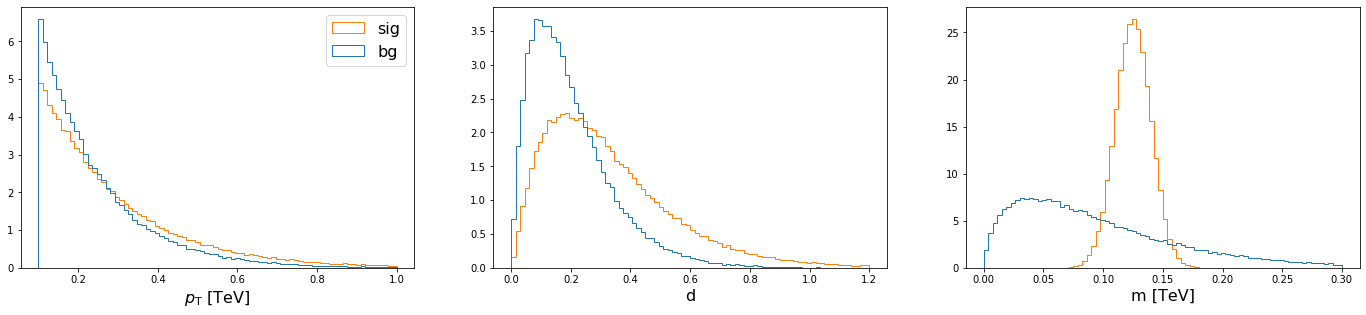

In [5]:
plt.figure(figsize=1.5*plt.figaspect(0.2))
plt.subplot(131)
plt.hist([x_train[y_train==0,0], x_train[y_train==1,0]], histtype='step', bins=80, density=True, label=('bg','sig'))
plt.xlabel(r'$p_\mathrm{T}$ [TeV]', fontsize=16);
plt.legend(fontsize=16);

plt.subplot(132)
plt.hist([x_train[y_train==0,1], x_train[y_train==1,1]], histtype='step', bins=80, range=(0,1.2), density=True)
plt.xlabel(r'd', fontsize=16);

plt.subplot(133)
plt.hist([x_train[y_train==0,2], x_train[y_train==1,2]], histtype='step', bins=80, range=(0,0.3), density=True)
plt.xlabel(r'm [TeV]', fontsize=16);

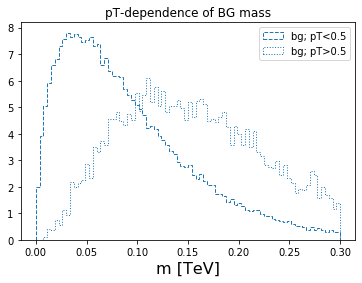

In [6]:
# check pT dependence of BG distribution
plt.figure()
plt.hist(x_train[(y_train==0)&(x_train[:,0]<0.5),2], histtype='step', bins=80, range=(0,0.3), density=True, ls='--', color='C0', label="bg; pT<0.5");
plt.hist(x_train[(y_train==0)&(x_train[:,0]>0.5),2], histtype='step', bins=80, range=(0,0.3), density=True, ls=':', color='C0', label="bg; pT>0.5");
plt.legend()
plt.title("pT-dependence of BG mass")
plt.xlabel(r'm [TeV]', fontsize=16);

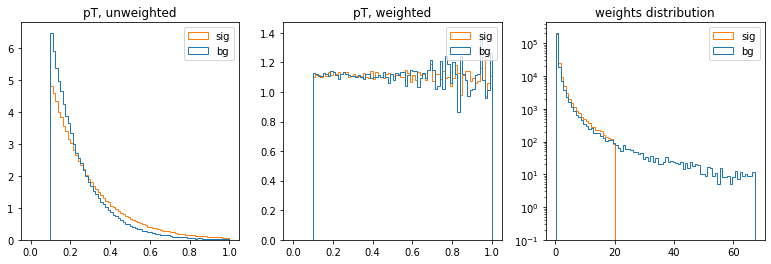

In [7]:
# check flat-pT weighting
plt.figure(figsize=plt.figaspect(0.3))
plt.subplot(131)
plt.hist([x[y==0,0], x[y==1,0]], histtype='step', bins=80, range=(0,1), density=True, label=('bg','sig'));
plt.title('pT, unweighted')
plt.legend()
plt.subplot(132)
plt.hist([x[y==0,0], x[y==1,0]], weights=[w[y==0],w[y==1]], histtype='step', bins=80, range=(0,1), density=True, label=('bg','sig'));
plt.title('pT, weighted')
plt.legend();
plt.subplot(133)
plt.hist([w[y==0],w[y==1]], histtype='step', bins=80, log=True, label=('bg','sig'));
plt.title('weights distribution')
plt.legend();

## Likelihood ratios
Now we can compute the Neyman-Pearson optimal discriminant for signal vs. bg, using the (log) likelihood ratio test statistic:
$$
q_{optimal} = -2\ln \frac{L_{sig}(p_\mathrm{T}, d, m)}{L_{bg}(p_\mathrm{T}, d, m)}
$$

We can also compute the likelihood excluding the terms for the mass- and/or $p_\mathrm{T}$ density from the likelihood (i.e. pretending we never saw these variables):
$$q_{optimal}^{-m} = -2\ln \frac{P_{sig,p_\mathrm{T}}(p_\mathrm{T})P_{sig,d}(d)}{P_{bg,p_\mathrm{T}}(p_\mathrm{T})P_{bg,d}(d)}$$
$$q_{optimal}^{-m,-p_\mathrm{T}} = -2 \ln \frac{P_{sig,d}(d)}{P_{bg,d}(d)}$$

These can be considered the _theoretically optimal discriminants which are decorrelated from mass_, for the given signal and BG likelihoods.

Note however that while we can write $q_{optimal}^{-m}$ without any explicit dependence on mass, we should still expect some posterior correlation with the mass since the background's $p_\mathrm{T}$ distribution is correlated to mass. In other words, the joint likelhood $L(p_\mathrm{T},m)=P(p_\mathrm{T})P(m|p_\mathrm{T})$ can not be made completely independent of mass by omitting the $P(m|p_\mathrm{T})$ term, since $P(p_\mathrm{T}) = P(m)P(p_\mathrm{T}|m) / P(m|p_\mathrm{T})$.

Therefore, in the presence of features that are correlated to the mass, the relevant theoretically-optimal decorrelated discriminant should be $q_{optimal}^{-m,-p_\mathrm{T}}$, which in this problem just amounts to utilizing the variable $d$ alone.
Nonetheless, we shall look at all three likelihood ratio discriminants in order to compare against the learned behavior of the DisCo NNs.

For now, we compute these ratios over the validation set, and visualize the likelhood distributions.

In [8]:
# Define convenience functions to evaluate signal and BG (log) likelihoods for given event(s) x=(pT,d,m).
# We also control whether the mass- and pT-dependent terms are included

def Lhood_bg(x, usemass=True, usept=True):
    pt,d,m = np.split(x,3,axis=-1)
    p = stats.gamma.logpdf(d,k_bg,0,theta_bg)
    if usept:
        p += stats.expon.logpdf(pt,loc=pt_min,scale=beta_bg)
    if usemass:
        p += stats.gamma.logpdf(m,1+4*pt,0,theta2_bg)
    return np.squeeze(p, axis=-1)

def Lhood_sig(x, usemass=True, usept=True):
    pt,d,m = np.split(x,3,axis=-1)
    p = stats.gamma.logpdf(d,k_sig,0,theta_sig)
    if usept:
        p += stats.expon.logpdf(pt,loc=pt_min,scale=beta_sig)
    if usemass:
        p += stats.norm.logpdf(m,loc=mu_sig, scale=sigma_sig)
    return np.squeeze(p,axis=-1)

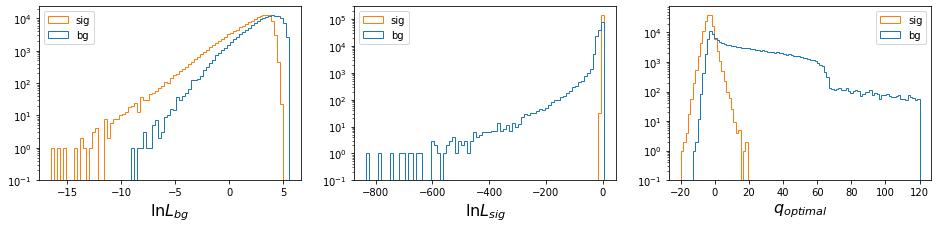

In [9]:
# compute signal likelihood, bg likelihood, and their ratio for every event in the validation set:
lbg = Lhood_bg(x_val)
lsig = Lhood_sig(x_val)
q0 = -2*(lsig-lbg)

plt.figure(figsize=plt.figaspect(0.2))
plt.subplot(131)
plt.hist([lbg[y_val==0], lbg[y_val==1]], histtype='step', bins=80, log=True, label=('bg','sig'));
plt.xlabel(r"$\ln L_{bg}$", fontsize=16)
plt.legend(loc='upper left')
plt.subplot(132)
plt.hist([lsig[y_val==0], lsig[y_val==1]], histtype='step', bins=80, log=True, label=('bg','sig'));
plt.xlabel(r"$\ln L_{sig}$", fontsize=16)
plt.legend(loc='upper left')
plt.subplot(133)
plt.hist([q0[y_val==0], q0[y_val==1]], histtype='step', bins=100, log=True, range=(-20,120), label=('bg','sig'))
plt.xlabel(r"$q_{optimal}$", fontsize=16)
plt.legend();

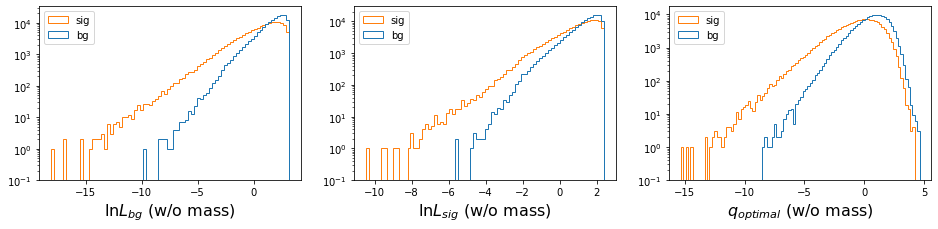

In [10]:
# compute signal likelihood, bg likelihood, and their ratio for every event in the validation set (without mass observable):
lbg_nm = Lhood_bg(x_val, usemass=False)
lsig_nm = Lhood_sig(x_val, usemass=False)
q0_nm = -2*(lsig_nm-lbg_nm)

plt.figure(figsize=plt.figaspect(0.2))
plt.subplot(131)
plt.hist([lbg_nm[y_val==0], lbg_nm[y_val==1]], histtype='step', bins=80, log=True, label=('bg','sig'));
plt.xlabel(r"$\ln L_{bg}$ (w/o mass)", fontsize=16)
plt.legend(loc='upper left')
plt.subplot(132)
plt.hist([lsig_nm[y_val==0], lsig_nm[y_val==1]], histtype='step', bins=80, log=True, label=('bg','sig'));
plt.xlabel(r"$\ln L_{sig}$ (w/o mass)", fontsize=16)
plt.legend(loc='upper left')
plt.subplot(133)
plt.hist([q0_nm[y_val==0], q0_nm[y_val==1]], histtype='step', bins=100, log=True, label=('bg','sig'))
plt.xlabel(r"$q_{optimal}$ (w/o mass)", fontsize=16)
plt.legend(loc='upper left');

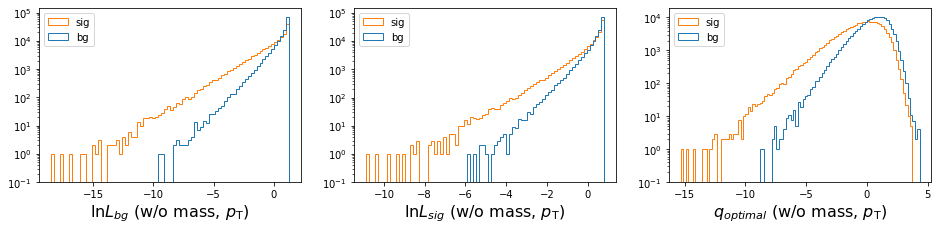

In [11]:
# compute signal likelihood, bg likelihood, and their ratio for every event in the validation set (without mass OR pT):
lbg_nmpt = Lhood_bg(x_val, usemass=False, usept=False)
lsig_nmpt = Lhood_sig(x_val, usemass=False, usept=False)
q0_nmpt = -2*(lsig_nmpt-lbg_nmpt)

plt.figure(figsize=plt.figaspect(0.2))
plt.subplot(131)
plt.hist([lbg_nmpt[y_val==0], lbg_nmpt[y_val==1]], histtype='step', bins=80, log=True, label=('bg','sig'));
plt.xlabel(r"$\ln L_{bg}$ (w/o mass, $p_\mathrm{T}$)", fontsize=16)
plt.legend(loc='upper left')
plt.subplot(132)
plt.hist([lsig_nmpt[y_val==0], lsig_nmpt[y_val==1]], histtype='step', bins=80, log=True, label=('bg','sig'));
plt.xlabel(r"$\ln L_{sig}$ (w/o mass, $p_\mathrm{T}$)", fontsize=16)
plt.legend(loc='upper left')
plt.subplot(133)
plt.hist([q0_nmpt[y_val==0], q0_nmpt[y_val==1]], histtype='step', bins=100, log=True, label=('bg','sig'))
plt.xlabel(r"$q_{optimal}$ (w/o mass, $p_\mathrm{T}$)", fontsize=16)
plt.legend(loc='upper left');

## Ideal metrics
The typical metrics used for comparing decorrelated taggers are R50 (background rejection @ 50% signal efficiency) and 1/JSD, where the Jenson-Shannon Divergence is evaluated between a histogram made of the include BG distribution vs. the BG distribution after cutting on the discriminator at the 50% signal efficiency working point.

We can calculate both of these here by first evaluating the median value of the $q_{optimal}$ test statistics for the signal distribution to get the 50% efficiency point. 

In [12]:
q50 = np.median(q0[y_val==1])
r50_ideal = 1./np.mean(q0[y_val==0]<q50)

q50_nm = np.median(q0_nm[y_val==1])
r50_ideal_nm = 1./np.mean(q0_nm[y_val==0]<q50_nm)

q50_nmpt = np.median(q0_nmpt[y_val==1])
r50_ideal_nmpt = 1./np.mean(q0_nmpt[y_val==0]<q50_nmpt)

print("Ideal rejection values")
print("opt:              %.1f"%r50_ideal)
print("opt w/o mass:     %.1f"%r50_ideal_nm)
print("opt w/o mass,pT:  %.1f"%r50_ideal_nmpt)

Ideal rejection values
opt:              22.3
opt w/o mass:     4.7
opt w/o mass,pT:  4.4


In [13]:
# helper function to compute the KL divergence correctly when p=0
def kl_safe(p,q):
    return np.sum(p*np.log(np.where(p>0, p/q, 1)))

mlow, mhi = np.quantile(x_val[y_val==0,2], [0.005,0.995])
h0,_ = np.histogram(x_val[y_val==0,2], bins=50, range=(mlow,mhi), density=True)
h1,_ = np.histogram(x_val[(y_val==0)&(q0<q50),2], bins=50, range=(mlow,mhi), density=True)
h1_nm,_ = np.histogram(x_val[(y_val==0)&(q0_nm<q50_nm),2], bins=50, range=(mlow,mhi), density=True)
h1_nmpt,_ = np.histogram(x_val[(y_val==0)&(q0_nmpt<q50_nmpt),2], bins=50, range=(mlow,mhi), density=True)

m = 0.5*(h0+h1)
jsd_ideal = 0.5*(kl_safe(h1, m) + kl_safe(h0, m))
m_nm = 0.5*(h0+h1_nm)
jsd_ideal_nm = 0.5*(kl_safe(h1_nm,m_nm) + kl_safe(h0, m_nm))
m_nmpt = 0.5*(h0+h1_nmpt)
jsd_ideal_nmpt = 0.5*(kl_safe(h1_nmpt,m_nmpt) + kl_safe(h0, m_nmpt))

jsd_ideal, jsd_ideal_nm, jsd_ideal_nmpt
print("Ideal 1/JSD values")
print("opt:              %.2e"%(1/jsd_ideal))
print("opt w/o mass:     %.2e"%(1/jsd_ideal_nm))
print("opt w/o mass,pT:  %.2e"%(1/jsd_ideal_nmpt))

Ideal 1/JSD values
opt:              1.85e-02
opt w/o mass:     1.69e+00
opt w/o mass,pT:  4.46e+01


## Distributions for ideal discriminant
Now we can plot the distributions before/after cutting on the idea discriminant to see the posterior effect it has on the BG distribution.
We are showing the distributions both with- and without the weights applied to flatten the $p_\mathrm{T}$ spectrum.

Note that the optimal discriminant produces extreme distortion of the background, while **the discriminant without mass or $p_\mathrm{T}$ information produce no discernable distortion**. The discriminant which uses $p_\mathrm{T}$ information without the mass produces a moderate amount of distortion; however, it does not afford a very large gain in rejection.

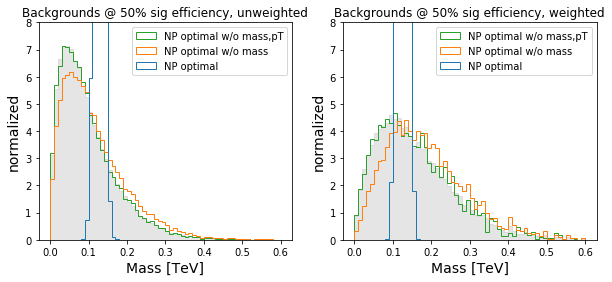

In [14]:
plt.figure(figsize=plt.figaspect(0.4))
plt.subplot(121)
plt.hist(x_val[y_val==0,2], histtype='step', bins=60, range=(0,0.6), density=True, color='gray', fill=True, alpha=0.2);
plt.hist([x_val[(q0<q50)&(y_val==0),2], x_val[(q0_nm<q50_nm)&(y_val==0),2],
          x_val[(q0_nmpt<q50_nmpt)&(y_val==0),2]], histtype='step', bins=60, range=(0,0.6), density=True,
         label=('NP optimal','NP optimal w/o mass', 'NP optimal w/o mass,pT'));
plt.title("Backgrounds @ 50% sig efficiency, unweighted")
plt.legend()
plt.ylabel('normalized')
plt.xlabel('Mass [TeV]')
plt.ylim(top=8)
plt.subplot(122)
plt.hist(x_val[y_val==0,2], weights=w_val[y_val==0], histtype='step', bins=60, range=(0,0.6), density=True, color='gray', fill=True, alpha=0.2);
plt.hist([x_val[(q0<q50)&(y_val==0),2], x_val[(q0_nm<q50_nm)&(y_val==0),2], x_val[(q0_nmpt<q50_nmpt)&(y_val==0),2]],
         weights=[w_val[(q0<q50)&(y_val==0)], w_val[(q0_nm<q50_nm)&(y_val==0)], w_val[(q0_nmpt<q50_nmpt)&(y_val==0)]],
         histtype='step', bins=60, range=(0,0.6), density=True,
         label=('NP optimal','NP optimal w/o mass', 'NP optimal w/o mass,pT')
        );
plt.legend()
plt.title("Backgrounds @ 50% sig efficiency, weighted")
plt.ylabel('normalized')
plt.xlabel('Mass [TeV]')
plt.ylim(top=8);

## DisCo NN implementation
Next up, we have a bunch of code to define our simple benchmark NN with disco loss function.
We also define a monitoring callback and some helper functions to run and visualize training experiments.

In [16]:
# Function to compute the weighted distance correlation between vectors a and b with weights w.
# The normalization of w doesn't matter here, since it gets normalized in the function.

#@tf.function
def disco(a, b, w):
    # compute pairwise distances between samples for variables a and b
    ajk = tf.abs(a[:,tf.newaxis] - a[tf.newaxis,:])
    bjk = tf.abs(b[:,tf.newaxis] - b[tf.newaxis,:])
    
    # ensure the weights are normalized
    w /= tf.reduce_sum(w)
    
    # convience views for w
    wj = w[:,tf.newaxis]
    wk = w[tf.newaxis,:]
    wjk = wj*wk
        
    # compute "doubly-centered" mean matrices
    ak = tf.reduce_sum(wj*ajk, axis=0, keepdims=True)
    Ajk = ajk - ak - tf.transpose(ak) + tf.reduce_sum(wjk*ajk)
    
    bk = tf.reduce_sum(wj*bjk, axis=0, keepdims=True)
    Bjk = bjk - bk - tf.transpose(bk) + tf.reduce_sum(wjk*bjk)

    dCov2_xy = tf.reduce_sum(wjk*Ajk*Bjk)
    
    dCov2_xx = tf.reduce_sum(wjk*Ajk*Ajk)
    dCov2_yy = tf.reduce_sum(wjk*Bjk*Bjk)
    
    if False:
        return dCov2_xx, dCov2_yy

    dCorr2_xy = dCov2_xy / tf.sqrt(tf.clip_by_value(dCov2_xx * dCov2_yy, 1e-9, 1e9))
    
    return dCorr2_xy

In [17]:
# Super simple 3-layer NN with a 2-node categorical output to train on the 3-dimensional dataset.
# The resulting model will have as an attribue a keras Variable (model.hp_lambda) that
# controls the disco term weight in the loss function. This value can be changed at any time (e.g. during training).

# NB: When training this model, the loss functions and metrics expect as input
# not only the truth labels but also the decorrelation variable (mass) and the event weights.
# The weights need to be passed along with y so that we can use the per-event weight information
# in the calculation of the disco loss.
# Although it would be possible to extract the reference mass from the input tensor for decorrelation,
# passing the mass through the y-value allows us to experiment with decorrelation against variables that
# are not included in the NN input.
# For practical purposes, this means two things:
# Firstly, when training/evaluating the network, you must concatenate the
# labels, masses, and weights together:
# z = np.concatenate([to_categorical(y_val,2), validation_masses, validation_weights], axis=-1)
# model.fit(x=x, y=z)
# Secondly, when implementing loss functions or metrics, the value of `y_true` will contain
# all three of these variables on the last axis, so the labels/mass/weights have to be unpacked.
# The value of `y_pred` will always just be whatever is output from the network model (in this case, 2-output softmax).

def mk_model(lambda_init=1.0):
    model_input = layers.Input((3,))
    
    x = model_input
    for _ in range(3):
        x = layers.Dense(100, activation='relu')(x)
    
    x = layers.Dense(2, activation='softmax')(x)
    model_output = x
    
    model = keras.models.Model(model_input, model_output)
    
    # create a variable to control the disco loss weight
    model.hp_lambda = tf.Variable(lambda_init, name='hp_lambda', trainable=False, dtype=tf.float32)
    
    # Note: wake definite separate functions for each of the independent loss terms;
    # this allows the individual terms to be monitored as metrics in the training history.
    
    # Categorical xentropy loss
    def loss_xe(yt,yp):
        # first unpack the truth labels, masses, and weights (we won't use the mass here).
        # note that since the y label is categorical format, it has a size of 2 on the last axis.
        yt,m,w = tf.split(yt, (2,1,1), axis=-1)
        
        # next compute the weighted categorical crossentropy. Note that the weights are
        # always scaled so that sum of weights = N_batch
        lxe = w[:,0]/tf.reduce_mean(w[:,0])*tf.losses.categorical_crossentropy(yt,yp)
        return lxe
    
    # Distance correlation term evaluated on BG events only
    def disco_bg(yt,yp):
        # unpack labels, mass, weights:
        yt,m,w = tf.split(yt, (2,1,1), axis=-1)
        
        is_bg = yt[:,0]==1
        return disco(yp[is_bg][:,0],m[is_bg][:,0],w[is_bg][:,0])
    
    # Distance correlation term evaluated on BG events only (not actually used, but could
    # be useful for monitoring purposes).
    def disco_sig(yt,yp):
        # unpack labels, mass, weights:
        yt,m,w = tf.split(yt, (2,1,1), axis=-1)
        
        is_sig = yt[:,1]==1
        return disco(yp[is_sig][:,0],m[is_sig][:,0],w[is_sig][:,0])
    
    # Define total loss function in terms of crossentropy and BG-only disco.
    # Note that we use the hp_lambda variable to control the relative weight.
    def loss(yt,yp):
        return loss_xe(yt,yp) + model.hp_lambda * disco_bg(yt,yp)
    
    # Metric to compute the background efficiency at 50% signal w.p.
    # Note that we calculate this rather than rejection, since the metric
    # is continuously updated as a running average over all batches.
    # The average of each batch's efficiency should equal the efficiency
    # over the whole dataset, but the average of 1/eff will not be correct.
    # Of course you can always plot 1/b50 to see the rejection.
    def b50(yt,yp):
        # unpack labels, mass, weights
        yt,m,w = tf.split(yt, (2,1,1), axis=-1)
        
        # compute median to find 50% signal efficiency
        # NOTE!!! This needs to be modified if you want to account for weights.
        ysig = yp[yt[:,1]>0.5][:,1]
        y50 = tfp.stats.percentile(ysig, 50., preserve_gradients=False)
        
        # compute BG efficiency of events w/ score above 50% w.p.
        ybg = yp[yt[:,1]<0.5][:,1]
        return tf.reduce_mean(tf.cast(ybg>y50,dtype=tf.float32))
    
    # Compile the model, specifying any of the above functions as metrics to be monitored.
    model.compile(optimizer='adam', loss=loss, metrics=['acc', b50, loss_xe, disco_bg, disco_sig])
    
    return model

In [15]:
# NB!!! This callback implementation assumes unweighted events, and will
# require some modification if your events are weighted.

# Keras Callback to compute the JSD between a reference dataset (x0,y0), and
# the model's predictions model(x0) at the end of each epoch.
# Constructor Arguments:
#  x0 - the reference dataset (i.e. validation data)
#  y0 - truth labels for the reference dataset
#  feature_idx - the index on the last axis of x0 corresponding to the feature of interest (e.g. mass)
#  bins - the number of histogram bins to use when computing JSD (original DisCo paper uses 50, although it could be very distribution-dependent)
#  batch_size - the batch size to use when predicting new labels at the end of each epoch
#  prefix - a string prefix for the metrics that will be logged in the model's training history
class JSDCallback(keras.callbacks.Callback):
    def __init__(self, x0, y0, feature_idx=2, bins=50, batch_size=1024, prefix='val_', **kwargs):
        super(JSDCallback, self).__init__(**kwargs)
        
        self.y0 = y0
        self.x0 = x0
        self.feature = feature_idx
        self.bins = bins
        self.batch_size = batch_size
        self.prefix = prefix
        
        # cache the original feature distribution, as well as a histogram
        # with the specified number of bins containing 99% of the data.
        # The point of omitting the most extreme 1% outliers is to try and limit the
        # nubmer of empty bins in the reference histogram.
        self.q = self.x0[self.y0==0,self.feature]
        self.xmin,self.xmax = np.quantile(self.q, [0.005,0.995])
        self.h_q,_ = np.histogram(self.q, self.bins, (self.xmin,self.xmax), density=True)
    
    def on_epoch_end(self, epoch, logs={}):
        # predict labels for the reference dataset using the current model state
        ypred = self.model.predict(self.x0,batch_size=self.batch_size)[:,1]
        
        # find the 50% signal efficiency working point
        y50 = np.median(ypred[self.y0==1])
        
        # grab the BG distribution after applying the 50% w.p. cut
        p = self.x0[(self.y0==0)&(ypred>y50),self.feature]

        # histogram of the 50% w.p. BG
        h_p,_ = np.histogram(p, self.bins, (self.xmin,self.xmax), density=True)

        # calculate JSD:
        M = 0.5*(h_p+self.h_q)
        jsd = 0.5*(kl_safe(h_p, M) + kl_safe(self.h_q, M))
        logs[self.prefix+'jsd'] = jsd
        
        # and while we're here, might as well log the R50 value:
        bg_eff = p.shape[0] / self.q.shape[0]
        logs[self.prefix+'R50'] = 1/bg_eff

In [18]:
# Convenience function to initialize a network and run a training experiment for a fixed value of lambda.
# If speified, the patience parameter is then maximum number of epochs without an improvement
# in the specified metric before halting training.

# Returns a dictionary with some metadata as well as the training history log.
def run_experiment(hp_lambda=1, max_epochs=200, patience=None, monitor='val_acc', use_weights=True, use_weights_val=False,
                   batch_size=1024, lr=1e-4, verbose=2):
    K.clear_session()
    
    model = mk_model()
    model.summary()
    
    callbacks = []
    
    # Initialize a callback to compute the JSD on the validation set after each epoch.
    # Note that this is not implemented like other metrics, as it cannot be
    # computed as a running average over the batches.
    cb_jsd = JSDCallback(x_val, y_val, batch_size=batch_size)
    callbacks.append(cb_jsd)
    
    # if patience is specified, set up the early stopping callback.
    if patience:
        if 'b50' in metric or 'jsd' in metric:
            mode = 'min'
        else:
            mode = 'auto'
        cb_stop = keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, mode=mode, verbose=1)
        callbacks.append(cb_stop)
    
    # NB: if we are not using weights, we still have to specify them since the model is expecting them.
    # we can just use an array of ones.
    if use_weights:
        wt = w_train
    else:
        wt = np.ones_like(w_train)
    if use_weights_val:
        wv = w_val
    else:
        wv = np.ones_like(w_val)
    
    # stack together the truth labels, reference masses, and weights:
    m_train = x_train[:,2]
    m_val   = x_val[:,2]
    Y_train = np.concatenate([to_categorical(y_train,2), m_train[:,np.newaxis], wt[:,np.newaxis]], axis=-1)
    Y_val   = np.concatenate([to_categorical(y_val,2), m_val[:,np.newaxis], wv[:,np.newaxis]], axis=-1)
    
    print("Setting lr=%g"%lr)
    K.set_value(model.optimizer.lr, lr)
    print("Setting lambda=%g"%hp_lambda)
    K.set_value(model.hp_lambda, hp_lambda)
    
    print("Using weights?",use_weights)
    
    print("Training for %d epochs begins..."%max_epochs)
    h = model.fit(
        x_train, Y_train,
        validation_data=(x_val, Y_val),
        verbose=verbose,
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
    )
    
    # record the value of metrics at the "best" epoch (at least according to the monitoring metric used for earlystopping).
    if monitor in ('val_acc',):
        i_best = np.argmax(h.history[monitor])
    elif monitor in ('val_b50', 'val_loss', 'val_loss_xe'):
        i_best = np.argmin(h.history[monitor])
    r50_best = 1./h.history['val_b50'][i_best]
    jsd_best = h.history['val_jsd'][i_best]
    
    # store experiment results and metadata
    experiment = {
        'history': h.history,
        'y_pred': model.predict(x_val, batch_size=1024),
        'hp_lambda': hp_lambda,
        'lr': lr,
        'use_weights': use_weights,
        'monitor': monitor,
        'jsd_best': jsd_best,
        'r50_best': r50_best,
    }
    
    return experiment

In [19]:
# Convenience function to plot the results of an experiment.
# Takes as input a dictionary like the one returned by run_experiment()
def plot_experiment(exp, nskip=2):
    h = exp['history']
        
    xep = np.arange(nskip,len(h['loss']))+1
    
    plt.figure(figsize=1.5*plt.figaspect(0.5))
    plt.subplot(221)
    plt.plot(xep, h['loss'][nskip:], color='C0', label='total (train)')
    plt.plot(xep, h['loss_xe'][nskip:], ls='--', color='C0', label='xentropy (train)')
    plt.plot(xep, h['val_loss'][nskip:], color='C1', label='total (val)')
    plt.plot(xep, h['val_loss_xe'][nskip:], ls='--', color='C1', label='xentropy (val)')
    plt.ylabel("total loss (xentropy loss)")
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(222)
    plt.plot(xep, h['disco_bg'][nskip:], color='C0', label='BG (train)')
    plt.plot(xep, h['disco_sig'][nskip:], ls='--', color='C0', label='sig (train)')
    plt.plot(xep, h['val_disco_bg'][nskip:], color='C1', label='BG (val)')
    plt.plot(xep, h['val_disco_sig'][nskip:], ls='--', color='C1', label='sig (val)')
    plt.legend()
    plt.ylabel("disco loss")
    plt.xlabel('epoch')
    plt.subplot(223)
    plt.plot(xep, h['acc'][nskip:], label='train')
    plt.plot(xep, h['val_acc'][nskip:], label='val')
    plt.ylabel("accuracy")
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(224)
    plt.plot(xep, 1./np.array(h['b50'][nskip:]), label='train')
    plt.plot(xep, 1./np.array(h['val_b50'][nskip:]), label='val')
    plt.ylabel("R50")
    plt.xlabel('epoch')
    plt.legend()
    ttype = 'weighted' if exp['use_weights'] else 'unweighted'
    plt.suptitle(r"$\lambda=%g$, %s training"%(exp['hp_lambda'],ttype), fontsize=16)
    
    y_pred = exp['y_pred'][:,1]
    y50 = np.median(y_pred[y_val==1])    

    plt.figure(figsize=plt.figaspect(0.3))
    plt.subplot(121)
    plt.hist([x_val[y_val==0,2],x_val[y_val==1,2]], histtype='step', bins=60, range=(0,0.3), label=('bg','sig'));
    plt.hist([x_val[(y_val==0)&(y_pred>y50),2],x_val[(y_val==1)&(y_pred>y50),2]], histtype='step', bins=60, range=(0,0.3),
             ls='--', color=('C0','C1'), label=('bg (50% w.p.)', 'sig (50% w.p.)'));
    plt.ylabel('events/bin')
    plt.xlabel('Mass [TeV]')
    plt.legend()
    plt.subplot(122)
    plt.hist(x_val[y_val==0,2], histtype='step', bins=60, range=(0,0.3), density=True, label='bg');
    plt.hist(x_val[(y_val==0)&(y_pred>y50),2], histtype='step', bins=60, range=(0,0.3), ls='--', color='C0', density=True, label='bg (50% w.p.)');
    plt.ylabel('Normalized')
    plt.xlabel('Mass [TeV]')
    plt.legend()
    plt.suptitle("Mass distributions @ epoch %d"  % xep[-1], fontsize=16)

In [20]:
# For a pair of vectors v_a, v_b, return only the elements that are
# on the pareto frontier of this set. The pareto condition is defined
# assuming the features a and b are to be maximized.
def pareto_front(v_a, v_b):
    to_keep = []
    for i,(a,b) in enumerate(zip(v_a,v_b)):
        if v_b[v_a>=a].max() == b:
            to_keep.append(i)
        elif v_a[v_b>=b].max() == a:
            to_keep.append(i)
    return np.array(to_keep)

# Convenience function to make a pareto plot in the R50-1/JSD plane for a list
# of experiments.
def pareto_plot(exps, all_points=True, color='black', lvals=None, s=15, alpha=1, emax=None):
    abest = []
    bbest = []
    lambdas = []
    if lvals is None:
        lvals = sorted(exps.keys())
    for l in lvals:
        a = 1./np.array(exps[l]['history']['val_b50'])
        b = 1./np.array(exps[l]['history']['val_jsd'])
        if emax is not None:
            a = a[:emax]
            b = b[:emax]
        if all_points:
            plt.scatter(a, b, alpha=0.2)
        idxs = pareto_front(a, b)
        abest.extend(a[idxs])
        bbest.extend(b[idxs])
        lambdas.extend([l]*len(idxs))
    abest = np.array(abest)
    bbest = np.array(bbest)
    lambdas = np.array(lambdas)
    ibest = pareto_front(abest, bbest)
    if color == 'lambda':
        sm = cm.ScalarMappable(cmap='jet')
        color = sm.to_rgba(lambdas[ibest])
        plt.colorbar(sm)
    plt.scatter(abest[ibest], bbest[ibest], s=s, color=color, alpha=alpha)
    plt.xscale('log')
    plt.yscale('log');

## Run experiments
We'll run some experiments for a range of lambda values.
The training epochs and range of lambda values is small for this demo, but you can play around with it.

In [21]:
# dictionary of trainnig experiment results (will be index by lambda)
# we will do experiments with and without weighted training data.
experiments_weighted = {}
experiments_unweighted = {}

In [22]:
# run experiments across a range of lambda values.
# we do not use early stopping so that we can examine the learning dynamics as
# a function of epochs, even after overtraining.
# Also, different learning rates seem to work better for weighted vs. unweighted.
max_epochs = 48
batch_size = 1024
verbose = 0

for lam in (0,1,2,4):
    experiments_weighted[lam] = run_experiment(hp_lambda=lam, use_weights=True,
                                               max_epochs=max_epochs, patience=None,
                                               batch_size=batch_size, lr=5e-5, verbose=verbose)
    
    experiments_unweighted[lam] = run_experiment(hp_lambda=lam, use_weights=False,
                                                 max_epochs=max_epochs, patience=None,
                                                 batch_size=batch_size, lr=1e-4, verbose=verbose)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 20,803
Trainable params: 20,802
Non-trainable params: 1
_________________________________________________________________
Setting lr=5e-05
Setting lambda=0
Using weights? True
Training begins...
Model: "model"
___________________________________

## Training curves
We can look at all our various metrics as a function of training epoch.
We also check the effect of the trained NN on the BG distribution at the 50% signal efficiency working point.

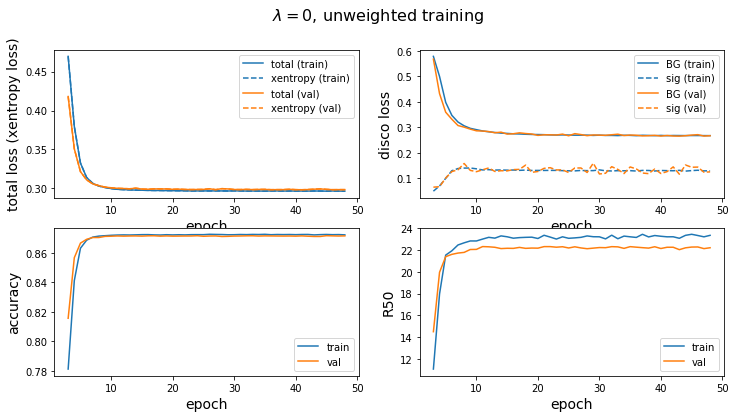

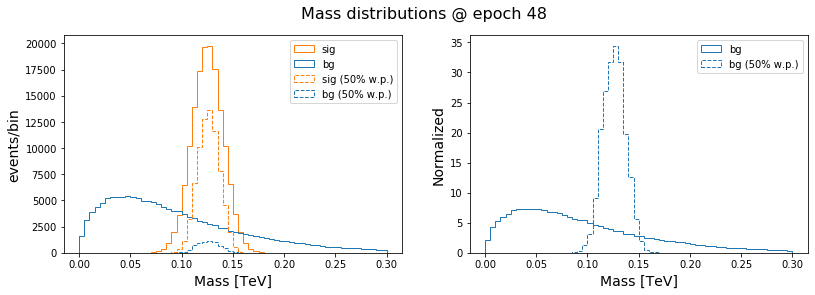

In [23]:
plot_experiment(experiments_unweighted[0])

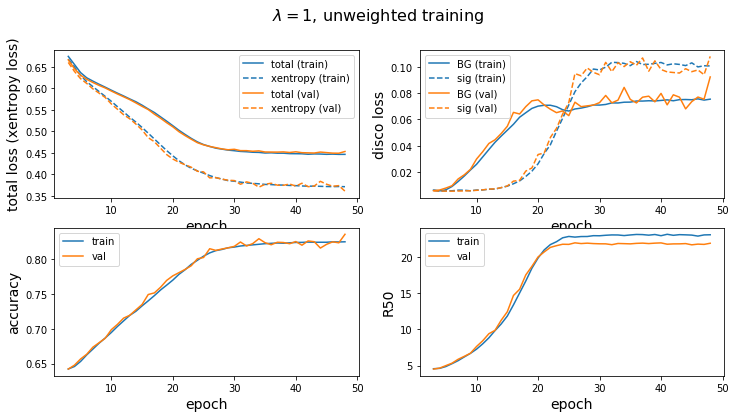

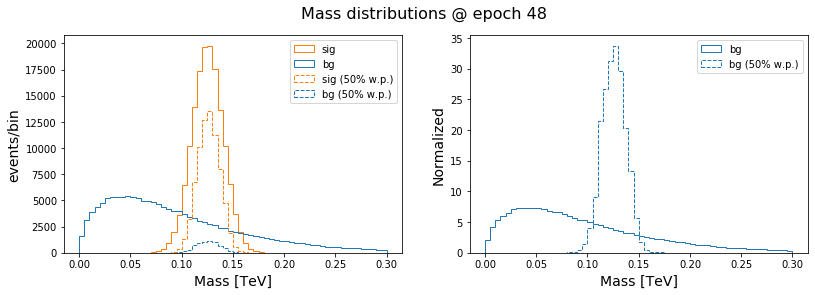

In [24]:
plot_experiment(experiments_unweighted[1])

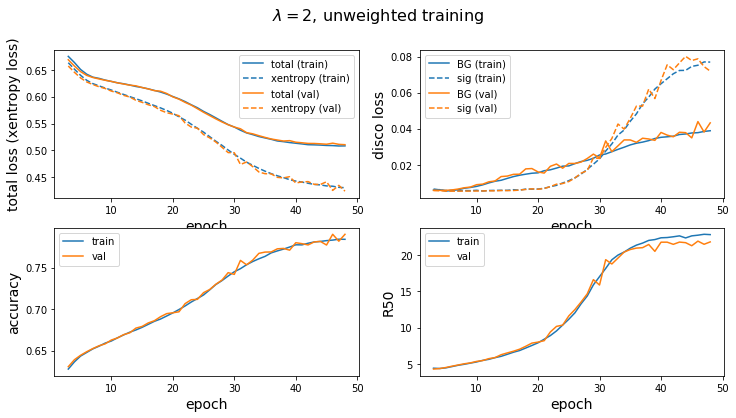

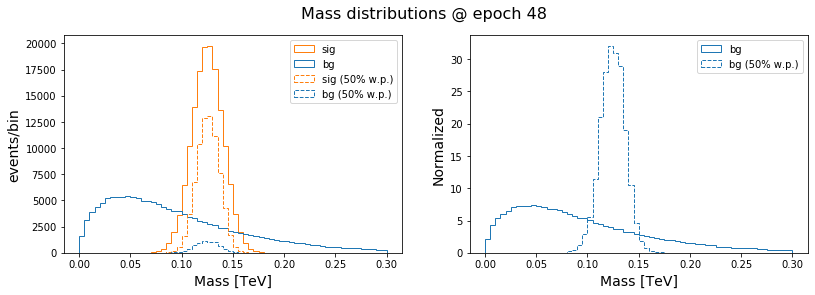

In [25]:
plot_experiment(experiments_unweighted[2])

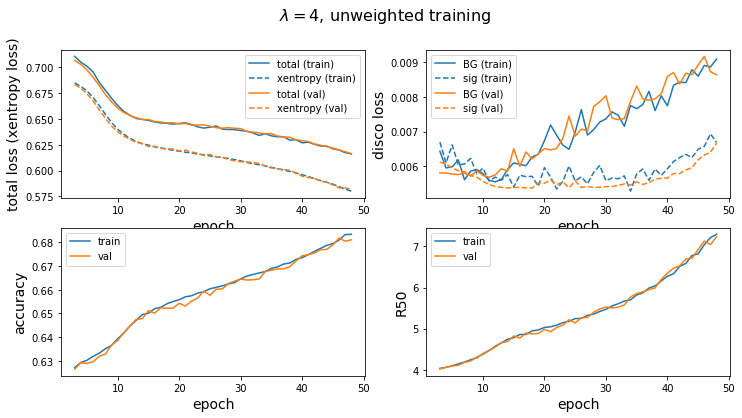

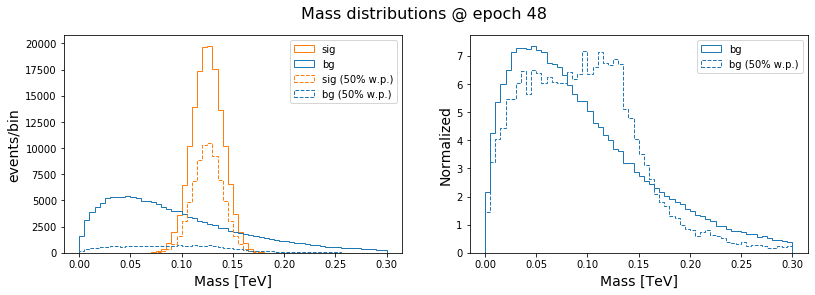

In [26]:
plot_experiment(experiments_unweighted[4])

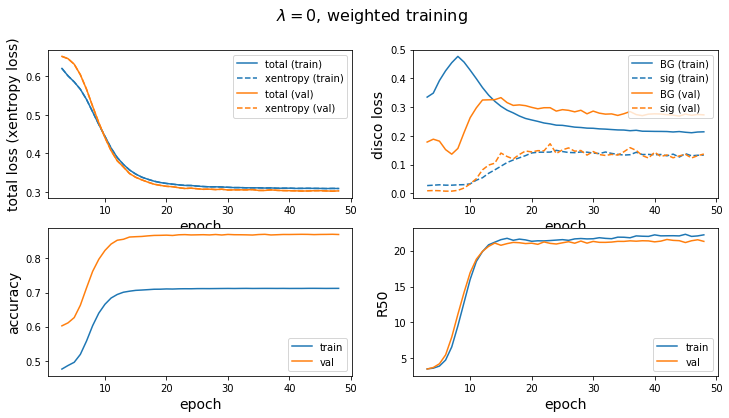

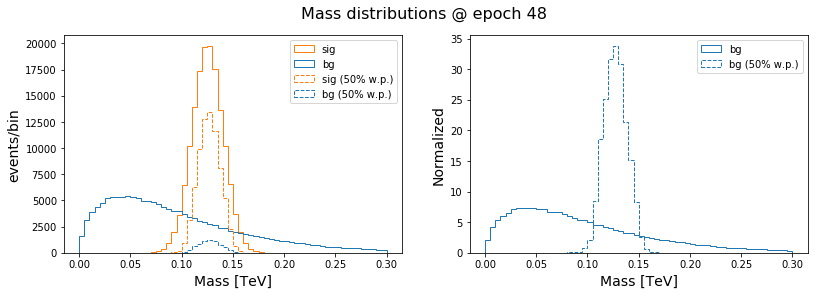

In [27]:
plot_experiment(experiments_weighted[0])

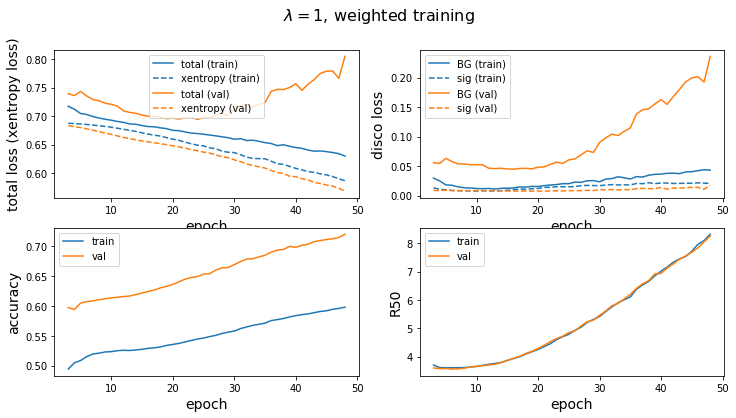

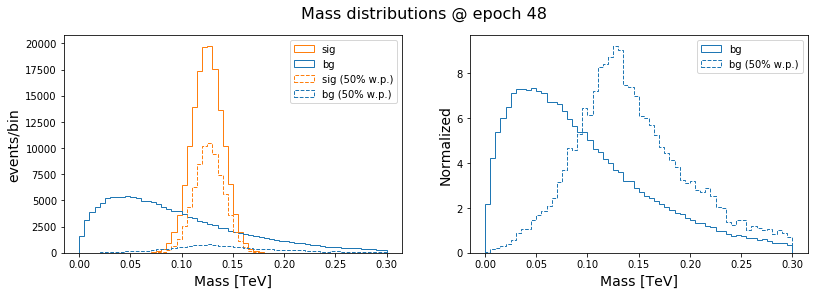

In [28]:
plot_experiment(experiments_weighted[1])

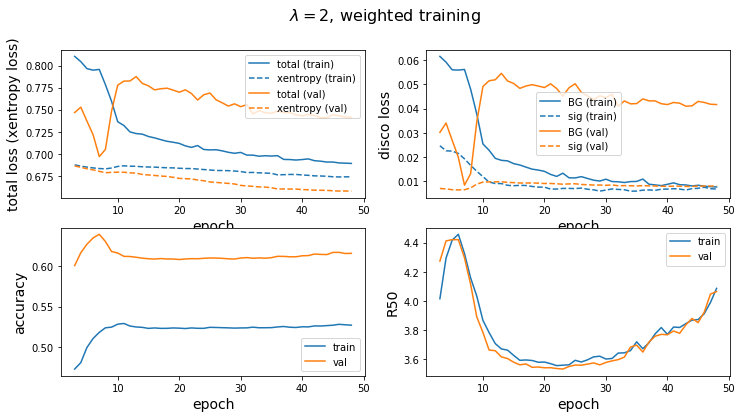

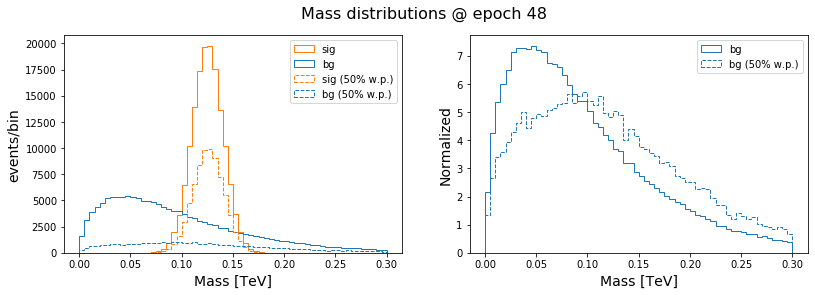

In [29]:
plot_experiment(experiments_weighted[2])

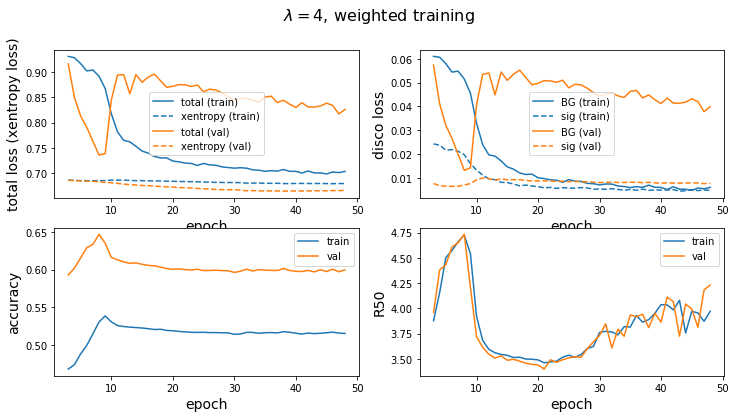

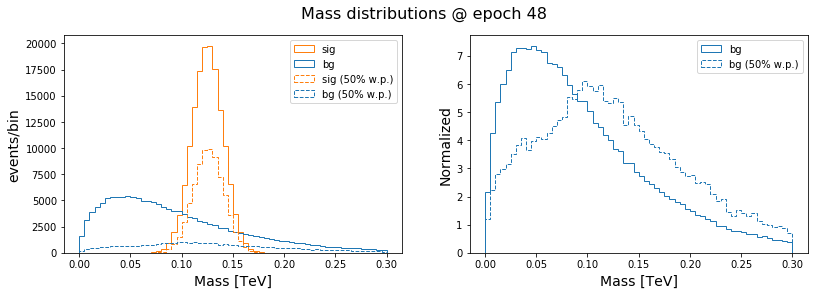

In [30]:
plot_experiment(experiments_weighted[4])

## R50-JSD curves
We can look at curves in the R50-JSD plane to evaluate NN power and decorrelation as a function of $\lambda$.
However, if we simply plot these curves at a fixed epoch (such as the last epoch, or the epoch with the lowest validation loss), we might not completely understand the full region of the R50-JSD plane that is spanned by these networks.
Some examples for various "best epoch" defnitions are shown here:

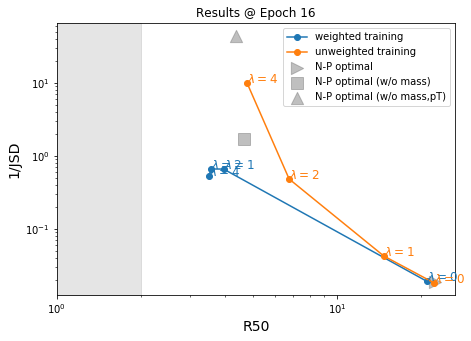

In [31]:
elast = 16

lambda_curve = np.array(sorted([(k,1./v['history']['val_b50'][elast-1],v['history']['val_jsd'][elast-1]) for k,v in experiments_weighted.items()]))
lambda_curve_unweighted = np.array(sorted([(k,1./v['history']['val_b50'][elast-1],v['history']['val_jsd'][elast-1]) for k,v in experiments_unweighted.items()]))

plt.figure(figsize=1.25*plt.figaspect(0.7))
plt.plot(lambda_curve[:,1], 1./lambda_curve[:,2], 'o-',  label='weighted training')
plt.plot(lambda_curve_unweighted[:,1], 1./lambda_curve_unweighted[:,2], 'o-', label='unweighted training')
for l,r,j in lambda_curve:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C0')
for l,r,j in lambda_curve_unweighted:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C1')
    
plt.scatter(r50_ideal, 1/jsd_ideal, color='gray', alpha=0.5, marker='>', s=150, label='N-P optimal')
plt.scatter(r50_ideal_nm, 1/jsd_ideal_nm, color='gray', alpha=0.5, marker='s', s=150, label='N-P optimal (w/o mass)')
plt.scatter(r50_ideal_nmpt, 1/jsd_ideal_nmpt, color='gray', alpha=0.5, marker='^', s=150, label='N-P optimal (w/o mass,pT)')

plt.ylabel('1/JSD')
plt.xlabel('R50')
plt.yscale('log')
plt.xscale('log');
ylow,yhi = plt.ylim()
plt.fill_betweenx([ylow,yhi], 1, 2, color='gray', alpha=0.2)
plt.title('Results @ Epoch %d'%elast)
plt.legend()
plt.xlim(left=1)
plt.ylim(ylow,yhi);

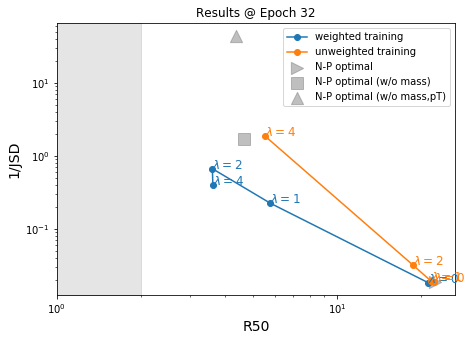

In [32]:
elast = 32

lambda_curve = np.array(sorted([(k,1./v['history']['val_b50'][elast-1],v['history']['val_jsd'][elast-1]) for k,v in experiments_weighted.items()]))
lambda_curve_unweighted = np.array(sorted([(k,1./v['history']['val_b50'][elast-1],v['history']['val_jsd'][elast-1]) for k,v in experiments_unweighted.items()]))

plt.figure(figsize=1.25*plt.figaspect(0.7))
plt.plot(lambda_curve[:,1], 1./lambda_curve[:,2], 'o-',  label='weighted training')
plt.plot(lambda_curve_unweighted[:,1], 1./lambda_curve_unweighted[:,2], 'o-', label='unweighted training')
for l,r,j in lambda_curve:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C0')
for l,r,j in lambda_curve_unweighted:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C1')
    
plt.scatter(r50_ideal, 1/jsd_ideal, color='gray', alpha=0.5, marker='>', s=150, label='N-P optimal')
plt.scatter(r50_ideal_nm, 1/jsd_ideal_nm, color='gray', alpha=0.5, marker='s', s=150, label='N-P optimal (w/o mass)')
plt.scatter(r50_ideal_nmpt, 1/jsd_ideal_nmpt, color='gray', alpha=0.5, marker='^', s=150, label='N-P optimal (w/o mass,pT)')

plt.ylabel('1/JSD')
plt.xlabel('R50')
plt.yscale('log')
plt.xscale('log');
ylow,yhi = plt.ylim()
plt.fill_betweenx([ylow,yhi], 1, 2, color='gray', alpha=0.2)
plt.title('Results @ Epoch %d'%elast)
plt.legend()
plt.xlim(left=1)
plt.ylim(ylow,yhi);

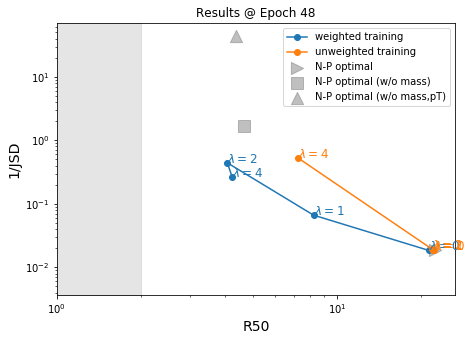

In [33]:
elast = 48

lambda_curve = np.array(sorted([(k,1./v['history']['val_b50'][elast-1],v['history']['val_jsd'][elast-1]) for k,v in experiments_weighted.items()]))
lambda_curve_unweighted = np.array(sorted([(k,1./v['history']['val_b50'][elast-1],v['history']['val_jsd'][elast-1]) for k,v in experiments_unweighted.items()]))

plt.figure(figsize=1.25*plt.figaspect(0.7))
plt.plot(lambda_curve[:,1], 1./lambda_curve[:,2], 'o-',  label='weighted training')
plt.plot(lambda_curve_unweighted[:,1], 1./lambda_curve_unweighted[:,2], 'o-', label='unweighted training')
for l,r,j in lambda_curve:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C0')
for l,r,j in lambda_curve_unweighted:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C1')
    
plt.scatter(r50_ideal, 1/jsd_ideal, color='gray', alpha=0.5, marker='>', s=150, label='N-P optimal')
plt.scatter(r50_ideal_nm, 1/jsd_ideal_nm, color='gray', alpha=0.5, marker='s', s=150, label='N-P optimal (w/o mass)')
plt.scatter(r50_ideal_nmpt, 1/jsd_ideal_nmpt, color='gray', alpha=0.5, marker='^', s=150, label='N-P optimal (w/o mass,pT)')

plt.ylabel('1/JSD')
plt.xlabel('R50')
plt.yscale('log')
plt.xscale('log');
ylow,yhi = plt.ylim()
plt.fill_betweenx([ylow,yhi], 1, 2, color='gray', alpha=0.2)
plt.title('Results @ Epoch %d'%elast)
plt.legend()
plt.xlim(left=1)
plt.ylim(ylow,yhi);

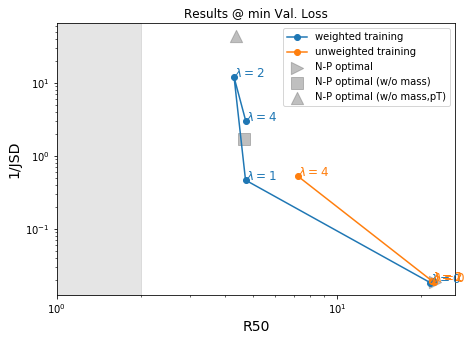

In [34]:
lambda_curve = np.array(sorted([(k,1./v['history']['val_b50'][np.argmin(v['history']['val_loss'])],v['history']['val_jsd'][np.argmin(v['history']['val_loss'])]) for k,v in experiments_weighted.items()]))
lambda_curve_unweighted = np.array(sorted([(k,1./v['history']['val_b50'][np.argmin(v['history']['val_loss'])],v['history']['val_jsd'][np.argmin(v['history']['val_loss'])]) for k,v in experiments_unweighted.items()]))

plt.figure(figsize=1.25*plt.figaspect(0.7))
plt.plot(lambda_curve[:,1], 1./lambda_curve[:,2], 'o-',  label='weighted training')
plt.plot(lambda_curve_unweighted[:,1], 1./lambda_curve_unweighted[:,2], 'o-', label='unweighted training')
for l,r,j in lambda_curve:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C0')
for l,r,j in lambda_curve_unweighted:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C1')
    
plt.scatter(r50_ideal, 1/jsd_ideal, color='gray', alpha=0.5, marker='>', s=150, label='N-P optimal')
plt.scatter(r50_ideal_nm, 1/jsd_ideal_nm, color='gray', alpha=0.5, marker='s', s=150, label='N-P optimal (w/o mass)')
plt.scatter(r50_ideal_nmpt, 1/jsd_ideal_nmpt, color='gray', alpha=0.5, marker='^', s=150, label='N-P optimal (w/o mass,pT)')

plt.ylabel('1/JSD')
plt.xlabel('R50')
plt.yscale('log')
plt.xscale('log');
ylow,yhi = plt.ylim()
plt.fill_betweenx([ylow,yhi], 1, 2, color='gray', alpha=0.2)
plt.title('Results @ min Val. Loss')
plt.legend()
plt.xlim(left=1)
plt.ylim(ylow,yhi);

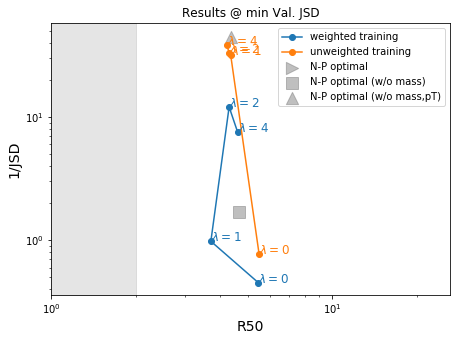

In [35]:
lambda_curve = np.array(sorted([(k,1./v['history']['val_b50'][np.argmin(v['history']['val_jsd'])],v['history']['val_jsd'][np.argmin(v['history']['val_jsd'])]) for k,v in experiments_weighted.items()]))
lambda_curve_unweighted = np.array(sorted([(k,1./v['history']['val_b50'][np.argmin(v['history']['val_jsd'])],v['history']['val_jsd'][np.argmin(v['history']['val_jsd'])]) for k,v in experiments_unweighted.items()]))

plt.figure(figsize=1.25*plt.figaspect(0.7))
plt.plot(lambda_curve[:,1], 1./lambda_curve[:,2], 'o-',  label='weighted training')
plt.plot(lambda_curve_unweighted[:,1], 1./lambda_curve_unweighted[:,2], 'o-', label='unweighted training')
for l,r,j in lambda_curve:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C0')
for l,r,j in lambda_curve_unweighted:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C1')
    
plt.scatter(r50_ideal, 1/jsd_ideal, color='gray', alpha=0.5, marker='>', s=150, label='N-P optimal')
plt.scatter(r50_ideal_nm, 1/jsd_ideal_nm, color='gray', alpha=0.5, marker='s', s=150, label='N-P optimal (w/o mass)')
plt.scatter(r50_ideal_nmpt, 1/jsd_ideal_nmpt, color='gray', alpha=0.5, marker='^', s=150, label='N-P optimal (w/o mass,pT)')

plt.ylabel('1/JSD')
plt.xlabel('R50')
plt.yscale('log')
plt.xscale('log');
ylow,yhi = plt.ylim()
plt.fill_betweenx([ylow,yhi], 1, 2, color='gray', alpha=0.2)
plt.title('Results @ min Val. JSD')
plt.legend()
plt.xlim(left=1)
plt.ylim(ylow,yhi);

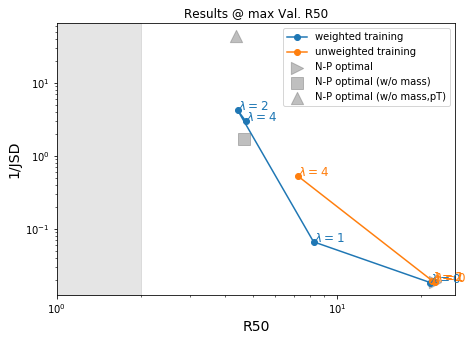

In [36]:
lambda_curve = np.array(sorted([(k,1./v['history']['val_b50'][np.argmin(v['history']['val_b50'])],v['history']['val_jsd'][np.argmin(v['history']['val_b50'])]) for k,v in experiments_weighted.items()]))
lambda_curve_unweighted = np.array(sorted([(k,1./v['history']['val_b50'][np.argmin(v['history']['val_b50'])],v['history']['val_jsd'][np.argmin(v['history']['val_b50'])]) for k,v in experiments_unweighted.items()]))

plt.figure(figsize=1.25*plt.figaspect(0.7))
plt.plot(lambda_curve[:,1], 1./lambda_curve[:,2], 'o-',  label='weighted training')
plt.plot(lambda_curve_unweighted[:,1], 1./lambda_curve_unweighted[:,2], 'o-', label='unweighted training')
for l,r,j in lambda_curve:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C0')
for l,r,j in lambda_curve_unweighted:
    plt.annotate(r"$\lambda = %g$"%l, (r, 1./j), fontsize=12, color='C1')
    
plt.scatter(r50_ideal, 1/jsd_ideal, color='gray', alpha=0.5, marker='>', s=150, label='N-P optimal')
plt.scatter(r50_ideal_nm, 1/jsd_ideal_nm, color='gray', alpha=0.5, marker='s', s=150, label='N-P optimal (w/o mass)')
plt.scatter(r50_ideal_nmpt, 1/jsd_ideal_nmpt, color='gray', alpha=0.5, marker='^', s=150, label='N-P optimal (w/o mass,pT)')

plt.ylabel('1/JSD')
plt.xlabel('R50')
plt.yscale('log')
plt.xscale('log');
ylow,yhi = plt.ylim()
plt.fill_betweenx([ylow,yhi], 1, 2, color='gray', alpha=0.2)
plt.title('Results @ max Val. R50')
plt.legend()
plt.xlim(left=1)
plt.ylim(ylow,yhi);

## Pareto front
Instead, we can plot the pareto frontier over ALL epochs and lambda values.
This allows us to consider a much larger set of points (each corresponding to a different trained NN) that can satisfy our notion of pareto efficiency.

Note that these frontiers traced out by the NN seem to interpolate between the optimal NP discriminants!

In [54]:
a_all = 1./np.concatenate([np.array(experiments_unweighted[k]['history']['val_b50']) for k in experiments_unweighted], axis=0)
b_all = 1./np.concatenate([np.array(experiments_unweighted[k]['history']['val_jsd']) for k in experiments_unweighted], axis=0)

pfront_idxs = pareto_front(a_all, b_all)
pfront_unweighted = np.stack([a_all[pfront_idxs], b_all[pfront_idxs]], axis=-1)

a_all = 1./np.concatenate([np.array(experiments_weighted[k]['history']['val_b50']) for k in experiments_weighted], axis=0)
b_all = 1./np.concatenate([np.array(experiments_weighted[k]['history']['val_jsd']) for k in experiments_weighted], axis=0)

pfront_idxs = pareto_front(a_all, b_all)
pfront_weighted = np.stack([a_all[pfront_idxs], b_all[pfront_idxs]], axis=-1)

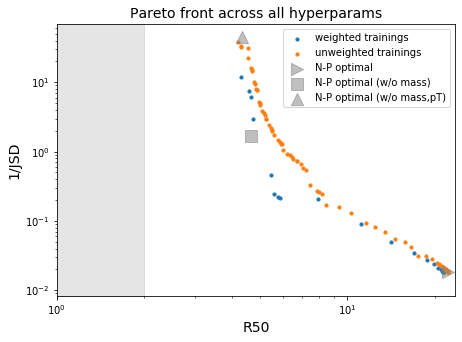

In [38]:
plt.figure(figsize=1.25*plt.figaspect(0.7))

plt.scatter(pfront_weighted[:,0], pfront_weighted[:,1], label='weighted trainings', s=10, color='C0')
plt.scatter(pfront_unweighted[:,0], pfront_unweighted[:,1], label='unweighted trainings', s=10, color='C1')
plt.scatter(r50_ideal, 1/jsd_ideal, color='gray', alpha=0.5, marker='>', s=150, label='N-P optimal')
plt.scatter(r50_ideal_nm, 1/jsd_ideal_nm, color='gray', alpha=0.5, marker='s', s=150, label='N-P optimal (w/o mass)')
plt.scatter(r50_ideal_nmpt, 1/jsd_ideal_nmpt, color='gray', alpha=0.5, marker='^', s=150, label='N-P optimal (w/o mass,pT)')
plt.xlim(left=1);
plt.xscale('log')
plt.yscale('log')
ylow,yhi = plt.ylim()
plt.fill_betweenx([ylow,yhi], 1, 2, color='gray', alpha=0.2)
plt.ylim(ylow,yhi)
plt.xlabel('R50', fontsize=14);
plt.ylabel('1/JSD', fontsize=14);
plt.title("Pareto front across all hyperparams", fontsize=14)

plt.legend();

## Animations
Lastly, we generate some visualizations to show where each NN is on the R50-JSD plane as the training progresses.
Hopefully this can give us some insight into how to tune the hyperparameters such as lambda and learning rate in order to train networks that are in the desired region of the plane.

In [39]:
# Function to produce an animated visualization of the NN training progress on the R50-JSD plane
from matplotlib import animation
from IPython.display import HTML

def animate_scatter(a,b,skip=None,xlim=None,ylim=None,title=None, shade=True, pfront=None):
    fig = plt.figure()
    
    if skip is None:
        skip = 1
    
    if pfront is not None:
        plt.scatter(pfront[:,0], pfront[:,1], color='lightgray', s=10)
        #idxs = np.argsort(pfront[:,0])
        #plt.plot(pfront[idxs,0], pfront[idxs,1], 'o:', color='lightgray')
        
    sc1 = plt.scatter(a[:1], b[:1], s=14, alpha=0.6)
    sc2 = plt.scatter(a[0], b[0], s=18, color='black', alpha=1)
    
    if xlim is None:
        xlim = (np.min(a)*0.8, np.max(a)*1.2)
    if ylim is None:
        ylim = (np.min(b)*0.8, np.max(b)*1.2)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    
    txt = plt.text(0.75,0.9, 'Epoch 0', fontsize=14, transform=plt.gca().transAxes)
    
    if xlim[0] < 2:
        ylow,yhi = plt.ylim()
        plt.fill_betweenx(ylim, xlim[0], 2, color='gray', alpha=0.2)
    
    plt.yscale('log')
    plt.xscale('log')
    
    plt.xlabel('R50', fontsize=14)
    plt.ylabel('1/JSD', fontsize=14)
    if title:
        plt.title(title, fontsize=14)
    
    def update(i):
        sc1.set_offsets(np.stack([a[:skip*i], b[:skip*i]], axis=-1))
        sc2.set_offsets(np.stack([a[skip*i:skip*i+1], b[skip*i:skip*i+1]], axis=-1))
        txt.set_text('Epoch %d'%(skip*i))
    
    return animation.FuncAnimation(fig, update, frames=len(a)//skip)

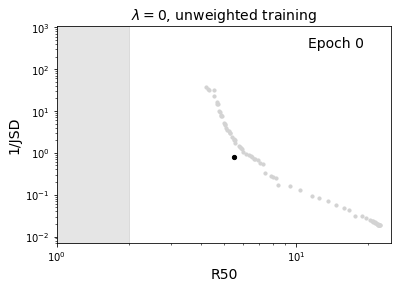

In [44]:
l = 0
e = experiments_unweighted
pfront = pfront_unweighted

a = 1./np.array(e[l]['history']['val_b50'])
b = 1./np.array(e[l]['history']['val_jsd'])

ttype = 'weighted' if e[l]['use_weights'] else 'unweighted'

HTML(animate_scatter(a,b,xlim=(1,25),ylim=(0.007,1100),title=r"$\lambda = %g$, %s training"%(l,ttype), pfront=pfront).to_html5_video())

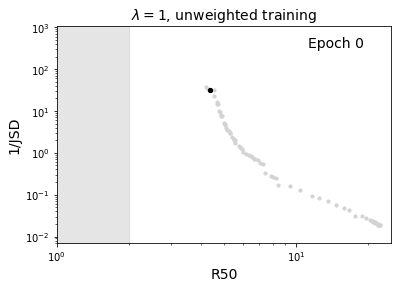

In [45]:
l = 1
e = experiments_unweighted
pfront = pfront_unweighted

a = 1./np.array(e[l]['history']['val_b50'])
b = 1./np.array(e[l]['history']['val_jsd'])

ttype = 'weighted' if e[l]['use_weights'] else 'unweighted'

HTML(animate_scatter(a,b,xlim=(1,25),ylim=(0.007,1100),title=r"$\lambda = %g$, %s training"%(l,ttype), pfront=pfront).to_html5_video())

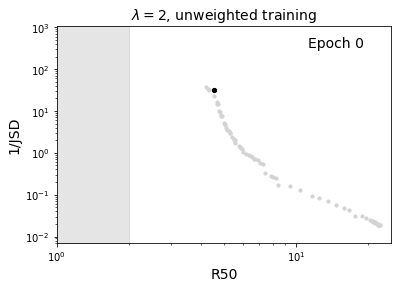

In [46]:
l = 2
e = experiments_unweighted
pfront = pfront_unweighted

a = 1./np.array(e[l]['history']['val_b50'])
b = 1./np.array(e[l]['history']['val_jsd'])

ttype = 'weighted' if e[l]['use_weights'] else 'unweighted'

HTML(animate_scatter(a,b,xlim=(1,25),ylim=(0.007,1100),title=r"$\lambda = %g$, %s training"%(l,ttype), pfront=pfront).to_html5_video())

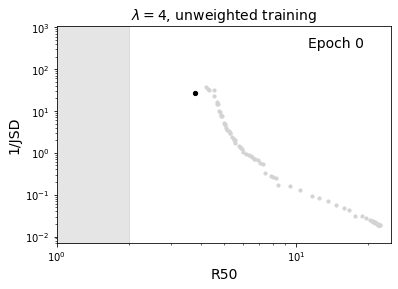

In [47]:
l = 4
e = experiments_unweighted
pfront = pfront_unweighted

a = 1./np.array(e[l]['history']['val_b50'])
b = 1./np.array(e[l]['history']['val_jsd'])

ttype = 'weighted' if e[l]['use_weights'] else 'unweighted'

HTML(animate_scatter(a,b,xlim=(1,25),ylim=(0.007,1100),title=r"$\lambda = %g$, %s training"%(l,ttype), pfront=pfront).to_html5_video())

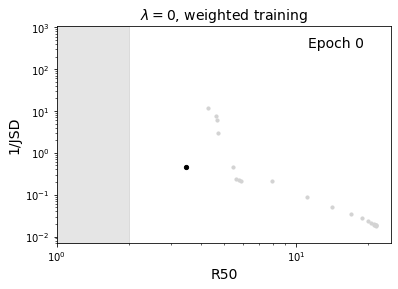

In [48]:
l = 0
e = experiments_weighted
pfront = pfront_weighted

a = 1./np.array(e[l]['history']['val_b50'])
b = 1./np.array(e[l]['history']['val_jsd'])

ttype = 'weighted' if e[l]['use_weights'] else 'unweighted'

HTML(animate_scatter(a,b,xlim=(1,25),ylim=(0.007,1100),title=r"$\lambda = %g$, %s training"%(l,ttype), pfront=pfront).to_html5_video())

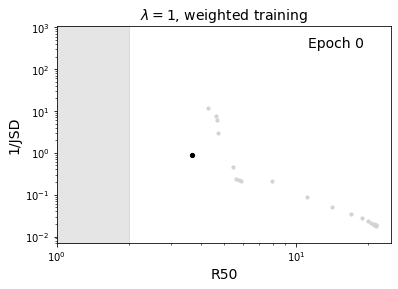

In [49]:
l = 1
e = experiments_weighted
pfront = pfront_weighted

a = 1./np.array(e[l]['history']['val_b50'])
b = 1./np.array(e[l]['history']['val_jsd'])

ttype = 'weighted' if e[l]['use_weights'] else 'unweighted'

HTML(animate_scatter(a,b,xlim=(1,25),ylim=(0.007,1100),title=r"$\lambda = %g$, %s training"%(l,ttype), pfront=pfront).to_html5_video())

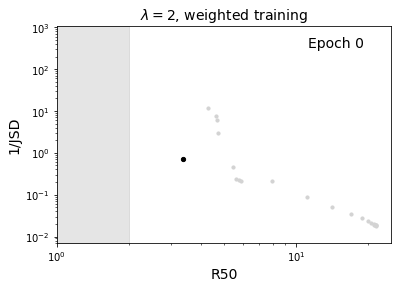

In [50]:
l = 2
e = experiments_weighted
pfront = pfront_weighted

a = 1./np.array(e[l]['history']['val_b50'])
b = 1./np.array(e[l]['history']['val_jsd'])

ttype = 'weighted' if e[l]['use_weights'] else 'unweighted'

HTML(animate_scatter(a,b,xlim=(1,25),ylim=(0.007,1100),title=r"$\lambda = %g$, %s training"%(l,ttype), pfront=pfront).to_html5_video())

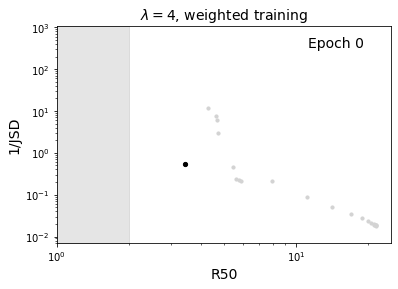

In [51]:
l = 4
e = experiments_weighted
pfront = pfront_weighted

a = 1./np.array(e[l]['history']['val_b50'])
b = 1./np.array(e[l]['history']['val_jsd'])

ttype = 'weighted' if e[l]['use_weights'] else 'unweighted'

HTML(animate_scatter(a,b,xlim=(1,25),ylim=(0.007,1100),title=r"$\lambda = %g$, %s training"%(l,ttype), pfront=pfront).to_html5_video())

In [52]:
# convienince function to return true when the last item of the paired list v_a,v_b
# is on the pareto frontier
def is_pareto(v_a,v_b):
    a0 = v_a[-1]
    b0 = v_b[-1]
    
    return (v_b[v_a>=a0].max() == b0) or (v_a[v_b>=b0].max() == a0)

Text(0.5, 1.0, '$\\lambda = 2$, unweighted training')

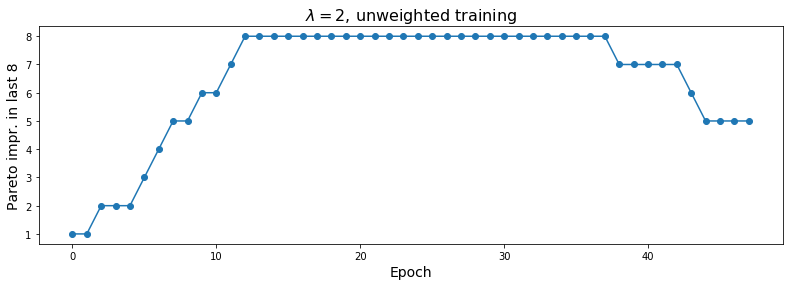

In [53]:
# Plot showing how many pareto-efficient improvements have been found in the last N epochs, as a function
# of epoch. When the curve hits zero, this corresponds to when an early stopping algorithm algorith would halt training.
l = 2
pat = 8

a = 1./np.array(experiments_unweighted[l]['history']['val_b50'])
b = 1./np.array(experiments_unweighted[l]['history']['val_jsd'])
isp = []
for i in range(len(a)):
    isp.append(is_pareto(a[:i+1],b[:i+1]))
plt.figure(figsize=plt.figaspect(0.3))
pct = np.convolve(isp, np.concatenate([np.ones(pat),np.zeros(pat-1)],axis=0), mode='full')[:len(isp)]
plt.plot(pct, 'o-')
if True in (pct==0):
    plt.axvline(np.argwhere(pct==0)[0][0], color='black', ls='--');
plt.xlabel("Epoch")
plt.ylabel("Pareto impr. in last %d" % pat)
plt.title(r"$\lambda = %g$, unweighted training"%l, fontsize=16)